<a href="https://colab.research.google.com/github/juhlianna/Detector-de-Fraudes-/blob/main/DesafioGerencianet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conectar ao banco e desenvolver as querys para obter os dados

Download do arquivo zip

In [1]:
from urllib import request
file_url = 'https://s3.amazonaws.com/gerencianet-pub-prod-1/printscreen/2021/desafio-tecnico.zip'
file = 'desafio-tecnico.zip'
request.urlretrieve(file_url , file )

('desafio-tecnico.zip', <http.client.HTTPMessage at 0x7f66c7db0ad0>)

Extraindo o zip

In [2]:
from zipfile import ZipFile
z = ZipFile(file, 'r')
z.extractall()
z.close()

Importando os dados do SQLite

In [40]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import joblib

import warnings
warnings.filterwarnings("ignore")
con = sqlite3.connect("desafio-tecnico.db")
print('\nConexão bem Sucedida\n')


Conexão bem Sucedida



Função para trasformar tabelas SQLite em DataFrame pandas

In [4]:
def parse_to_df(table,database):
    con = sqlite3.connect(database)
    query = ''' SELECT * FROM '''+table
    df = pd.read_sql_query(query, con)
    return df

1.Accounts.Tabela que apresenta as informações cadastrais de cada conta.

In [5]:
df_accounts = parse_to_df('accounts',"desafio-tecnico.db")

In [6]:
df_accounts.head()

,id,account_number,birth,occupation,email,address_id,created_at
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00


2.Address.Tabela que identifica os pares de estado e cidade. Para verificar a residência de cada conta é necessário realizar o join com esta tabela.

In [7]:
df_address = parse_to_df('address','desafio-tecnico.db')
df_address.head()

,id,state,city,created_at
0,1,RJ,Carmo,2021-04-01 02:30:00
1,2,MG,Bertopolis,2021-04-01 02:00:00
2,3,MG,Olaria,2021-04-01 11:30:00
3,4,PR,Icaraima,2021-04-01 14:30:00
4,5,ES,Ecoporanga,2021-04-02 15:30:00


3.Levels.Cada conta recebe uma classificação de acordo com a forma que utiliza a plataforma. Contas que utilizam com maior consistência ou com grande potêncial podem receber uma melhor classificação (A>B>C>D). Caso identifique-se que a conta possui características suspeitas, de fraude, é atribuida a categoria F e executado o encerramento.

In [8]:
df_levels = parse_to_df('levels','desafio-tecnico.db')
df_levels.head()

,id,account_number,level,created_at
0,1,155938,F,2021-04-20 08:00:00
1,2,747007,D,2021-04-19 19:30:00
2,4,66402,D,2021-04-28 21:00:00
3,5,277012,D,2021-04-19 12:00:00
4,6,228213,D,2021-04-26 15:00:00


In [9]:
df_levels.level.unique()

array(['F', 'D', 'C', 'A', 'B'], dtype=object)

In [10]:
df_levels.account_number.nunique()

926

4. Charges. Tabela apresenta as emissões de boletos realizadas pelos clientes com os respectivos status de pago ou não.

In [11]:
df_charges = parse_to_df('charges','desafio-tecnico.db')
df_charges.head()

,id,account_number,status,value,created_at
0,1,155938,paid,11992,2021-04-01 03:00:00
1,2,155938,paid,9689,2021-04-01 13:30:00
2,3,155938,paid,11579,2021-04-01 11:30:00
3,4,747007,unpaid,3134,2021-04-02 12:00:00
4,5,747007,paid,3085,2021-04-02 19:00:00


5. Transactions. Tabela com as transações efetivadas por cada conta, logo, caso um boleto tenha sido pago esta informação estará presente nesta tabela e na tabela charges.

In [12]:
df_transactions = parse_to_df('transactions','desafio-tecnico.db')
df_transactions.head()

,id,account_number,transaction_type_id,value,created_at
0,1,155938,1,11992,2021-04-01 03:00:00
1,2,155938,1,9689,2021-04-01 13:30:00
2,3,155938,1,11579,2021-04-01 11:30:00
3,4,155938,3,11168,2021-04-01 11:00:00
4,5,155938,3,10772,2021-04-01 21:00:00


6. Transaction_type. Tabela que permite identificar qual o tipo de cada transação da tabela transactions.

In [13]:
df_transaction_type = parse_to_df('transaction_type','desafio-tecnico.db')
df_transaction_type.head()

,id,description,description_long
0,1,boleto_recebido,BOLETO RECEBIDO PELO CLIENTE
1,2,pix_enviado,PIX ENVIADO PELO CLIENTE PARA UMA CONTA EXTERNA
2,3,pix_recebido,PIX RECEBIDO PELO CLIENTE


Junção da tabela de contas com a tabela de endereços

In [14]:
df_address['address_id'] = df_address['id']
df_accounts_with_address = pd.merge(df_accounts, df_address, how='left', on='address_id')
df_accounts_with_address.shape

(1029, 11)

Renomeando as colunas 

In [15]:
df_accounts_with_address.rename(columns={'id_x':'id_acc','id_y':'id_add','created_at_x':'created_at_acc'},inplace=True)

In [16]:
df_accounts_with_address.drop(columns=['created_at_y'], inplace=True)

In [17]:
df_accounts_with_address.head()

,id_acc,account_number,birth,occupation,email,address_id,created_at_acc,id_add,state,city
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00,1,RJ,Carmo
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00,2,MG,Bertopolis
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00,3,MG,Olaria
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00,4,PR,Icaraima
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00,5,ES,Ecoporanga


Junção das Tabelas de accounts/address com a Tabela de Levels

In [18]:
df_accounts_with_address_levels = pd.merge(df_accounts_with_address, df_levels, how='left', on='account_number')
df_accounts_with_address_levels.shape

(1029, 13)

In [19]:
df_accounts_with_address_levels.drop(columns=['created_at'],inplace=True)
df_accounts_with_address_levels

,id_acc,account_number,birth,occupation,email,address_id,created_at_acc,id_add,state,city,id,level
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00,1,RJ,Carmo,1.0,F
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00,2,MG,Bertopolis,2.0,D
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00,3,MG,Olaria,NaN,NaN
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00,4,PR,Icaraima,4.0,D
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00,5,ES,Ecoporanga,5.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
1024,1025,385922,2003-05-20,Analista,evelynviana3@example.com,745,2021-07-10 03:30:00,745,GO,Monte Alegre de Goias,1025.0,D
1025,1026,37393,1996-01-20,Investidor,anaclaraporto9@example.com,505,2021-07-10 04:30:00,505,PR,Paraiso do Norte,1026.0,C
1026,1027,714025,1981-07-21,Corretor,miguelribeiro3@example.com,746,2021-07-10 15:00:00,746,GO,Sao Luis de Montes Belos,1027.0,D
1027,1028,708615,1967-03-14,Corretor,mariaeduardadarocha@example.com,747,2021-07-10 21:30:00,747,SC,Zortea,1028.0,D


**Tratamento dos dados** 

Para facilitar a visualização, manipularemos nossas tabela obtidas em formato de DataFrame:

In [21]:
#criar dataframes
df_accounts = pd.read_sql_query(f'SELECT * FROM accounts', con)    
df_address = pd.read_sql_query(f'SELECT * FROM address', con)  
df_levels = pd.read_sql_query(f'SELECT * FROM levels', con)
df_charges = pd.read_sql_query(f'SELECT * FROM charges', con)
df_transactions = pd.read_sql_query(f'SELECT * FROM transactions', con)
df_transaction_type = pd.read_sql_query(f'SELECT * FROM transaction_type', con)

Juntar as tabelas dimensão df_accounts, df_address e df_levels em um único df_dim:

As tabelas dimensão df_address e df_levels são características relacionadas a tabela dimensão df_accounts. Para não termos todas estas informações espalhadas, criaremos um único df_dim contendo todas as características das contas de uma forma mais detalhada.

In [22]:
join_accounts_address_levels = '''
                                SELECT
                                    accounts.id,
                                    accounts.account_number,
                                    accounts.birth, 
                                    accounts.occupation,
                                    accounts.email,
                                    accounts.address_id,
                                    accounts.created_at AS created_account,
                                    address.state,
                                    address.city,
                                    address.created_at AS created_address,
                                    levels.level,
                                    levels.created_at AS created_level
                                FROM 
                                    accounts
                                LEFT JOIN address
                                    ON accounts.address_id = address.id
                                        LEFT JOIN levels
                                            ON accounts.account_number = levels.account_number
                               '''
df_dim = pd.read_sql(join_accounts_address_levels, con)

Criando a característica is_Fraud:

In [23]:
df_dim['is_Fraud'] = df_dim['level'].replace({'A':0, 'B':0, 'C':0, 'D':0, 'F':1})
df_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1029 non-null   int64  
 1   account_number   1029 non-null   int64  
 2   birth            1029 non-null   object 
 3   occupation       1029 non-null   object 
 4   email            1029 non-null   object 
 5   address_id       1029 non-null   int64  
 6   created_account  1029 non-null   object 
 7   state            1029 non-null   object 
 8   city             1029 non-null   object 
 9   created_address  1029 non-null   object 
 10  level            926 non-null    object 
 11  created_level    926 non-null    object 
 12  is_Fraud         926 non-null    float64
dtypes: float64(1), int64(3), object(9)
memory usage: 104.6+ KB


Vamos corrigir este formato para datetime, mais indicado para trabalhar estes dados, para melhorar o formato.

In [24]:
aux = ['birth', 'created_account', 'created_address', 'created_level']
for coluna in aux:
    df_dim[coluna] = pd.to_datetime(df_dim[coluna])    
df_dim[aux].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   birth            1029 non-null   datetime64[ns]
 1   created_account  1029 non-null   datetime64[ns]
 2   created_address  1029 non-null   datetime64[ns]
 3   created_level    926 non-null    datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 32.3 KB


Agora vamos criar uma coluna age contendo a idade dos clientes em 2022.

Criando a coluna age:

In [38]:
df_dim['age'] = 2022 - df_dim['birth'].dt.year

Inserindo a informação de charges:
criação de variavel paid (Contém a qtd de boletos que foram pagos)
e unpaid (Contém a qtd de boletos não pagos)

In [41]:
df_charges_group = df_charges.groupby(['account_number','status']).count().reset_index()[['account_number','status','value']]
df_charges_group = df_charges_group.pivot(index="account_number", columns="status", values="value").reset_index().fillna(0)
df_charges_group

status,account_number,paid,unpaid
0,2711,144.0,75.0
1,2763,128.0,95.0
2,2957,32.0,30.0
3,3478,18.0,18.0
4,5561,26.0,40.0
...,...,...,...
875,995447,136.0,138.0
876,997838,23.0,70.0
877,998364,110.0,25.0
878,998440,25.0,19.0


Juntando atraves de join a informação de df_charges_group com df_accounts_with_address_levels

In [42]:
df_accounts_with_address_levels_charges = pd.merge(df_accounts_with_address_levels, df_charges_group, how='left', on='account_number')
print(df_accounts_with_address_levels_charges.shape)
df_accounts_with_address_levels_charges.head()

(1029, 14)


,id_acc,account_number,birth,occupation,email,address_id,created_at_acc,id_add,state,city,id,level,paid,unpaid
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00,1,RJ,Carmo,1.0,F,30.0,39.0
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00,2,MG,Bertopolis,2.0,D,113.0,153.0
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00,3,MG,Olaria,NaN,NaN,64.0,79.0
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00,4,PR,Icaraima,4.0,D,184.0,33.0
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00,5,ES,Ecoporanga,5.0,D,90.0,112.0


Preenchendo os NaN de paid e unpaid com 0.

In [43]:
df_accounts_with_address_levels_charges[['paid','unpaid']].info()
print(f"-"*40)
print(f":::> Quantidade de NaN em paid e unpaid")
df_accounts_with_address_levels_charges[['paid','unpaid']].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 0 to 1028
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   paid    880 non-null    float64
 1   unpaid  880 non-null    float64
dtypes: float64(2)
memory usage: 24.1 KB
----------------------------------------
:::> Quantidade de NaN em paid e unpaid


paid      149
unpaid    149
dtype: int64

Preenchendo os NaN de charger com 0

In [44]:
df_accounts_with_address_levels_charges['paid'].fillna(0, inplace=True)
df_accounts_with_address_levels_charges['unpaid'].fillna(0, inplace=True)

Convertendo as colunas paid e unpaid em inteiro

In [45]:
df_accounts_with_address_levels_charges['paid'] = df_accounts_with_address_levels_charges['paid'].astype(int)
df_accounts_with_address_levels_charges['unpaid'] = df_accounts_with_address_levels_charges['unpaid'].astype(int)

In [46]:
df_accounts_with_address_levels_charges.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 0 to 1028
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_acc          1029 non-null   int64  
 1   account_number  1029 non-null   int64  
 2   birth           1029 non-null   object 
 3   occupation      1029 non-null   object 
 4   email           1029 non-null   object 
 5   address_id      1029 non-null   int64  
 6   created_at_acc  1029 non-null   object 
 7   id_add          1029 non-null   int64  
 8   state           1029 non-null   object 
 9   city            1029 non-null   object 
 10  id              926 non-null    float64
 11  level           926 non-null    object 
 12  paid            1029 non-null   int64  
 13  unpaid          1029 non-null   int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 120.6+ KB


Descritiva do Dataset com os merges(join)

In [47]:
df_accounts_with_address_levels_charges.describe()

,id_acc,account_number,address_id,id_add,id,paid,unpaid
count,1029.000000,1029.000000,1029.000000,1029.000000,926.000000,1029.000000,1029.000000
mean,515.000000,500230.235180,340.163265,340.163265,518.062635,94.059281,56.056365
std,297.191016,291393.973271,213.681298,213.681298,297.499508,99.035757,58.770052
min,1.000000,2711.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,258.000000,253345.000000,148.000000,148.000000,259.250000,20.000000,20.000000
50%,515.000000,494349.000000,328.000000,328.000000,522.500000,78.000000,42.000000
75%,772.000000,747007.000000,518.000000,518.000000,772.750000,134.000000,77.000000
max,1029.000000,999828.000000,747.000000,747.000000,1029.000000,764.000000,534.000000


In [48]:
df_accounts_with_address_levels_charges.tail()

,id_acc,account_number,birth,occupation,email,address_id,created_at_acc,id_add,state,city,id,level,paid,unpaid
1024,1025,385922,2003-05-20,Analista,evelynviana3@example.com,745,2021-07-10 03:30:00,745,GO,Monte Alegre de Goias,1025.0,D,0,0
1025,1026,37393,1996-01-20,Investidor,anaclaraporto9@example.com,505,2021-07-10 04:30:00,505,PR,Paraiso do Norte,1026.0,C,0,0
1026,1027,714025,1981-07-21,Corretor,miguelribeiro3@example.com,746,2021-07-10 15:00:00,746,GO,Sao Luis de Montes Belos,1027.0,D,0,0
1027,1028,708615,1967-03-14,Corretor,mariaeduardadarocha@example.com,747,2021-07-10 21:30:00,747,SC,Zortea,1028.0,D,0,0
1028,1029,418641,1992-06-10,Corretor,heitordaluz@example.com,12,2021-07-10 02:00:00,12,RJ,Italva,1029.0,F,1,0


Visualizando boletos pagos e não pagos por estado

In [49]:
df_paid_unpaid_to_state = df_accounts_with_address_levels_charges.groupby(['state']).sum().reset_index()[['state','paid','unpaid']]
df_paid_unpaid_to_state

,state,paid,unpaid
0,BA,5311,2508
1,ES,11736,7234
2,GO,4801,2635
3,MG,33597,19057
4,PR,14903,11264
5,RJ,14503,9824
6,SC,6170,2403
7,SP,5766,2757


In [50]:
data_plot = df_paid_unpaid_to_state[['state','unpaid']].sort_values('unpaid',ascending=False)

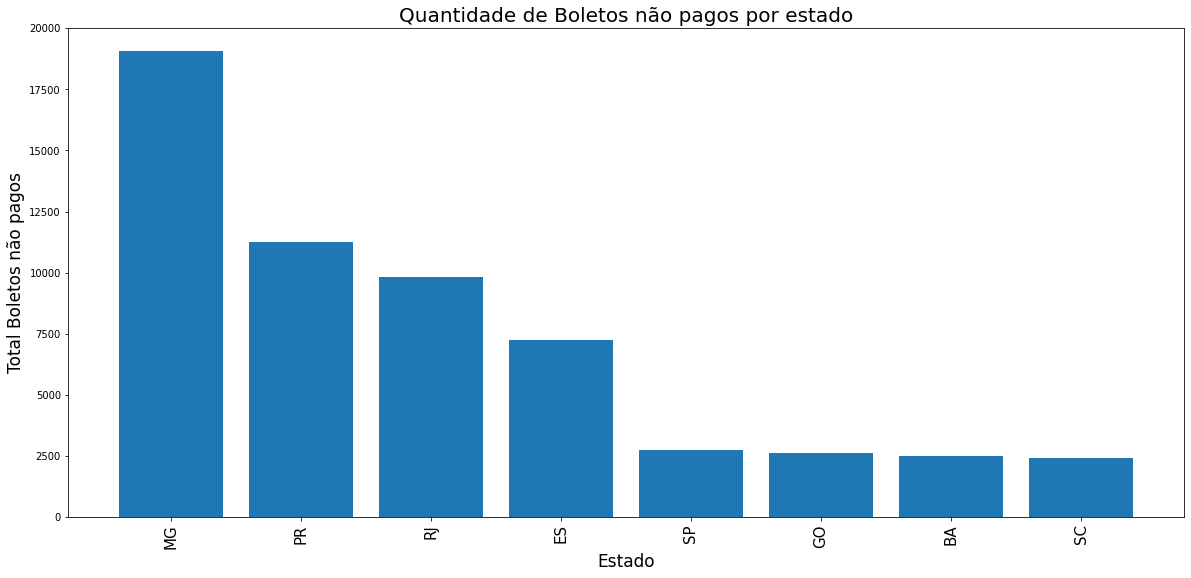

In [51]:
f,ax = plt.subplots(figsize=(20,9))

data_plot = df_paid_unpaid_to_state[['state','unpaid']].sort_values('unpaid',ascending=False)

ax.bar(data_plot['state'],data_plot['unpaid'])
ax.set_xticklabels(data_plot['state'].values,rotation=90,fontsize='15')
ax.set_xlabel('Estado',fontsize='17')
ax.set_ylabel('Total Boletos não pagos',fontsize='17')
ax.set_title('Quantidade de Boletos não pagos por estado',fontsize='20')
plt.show()

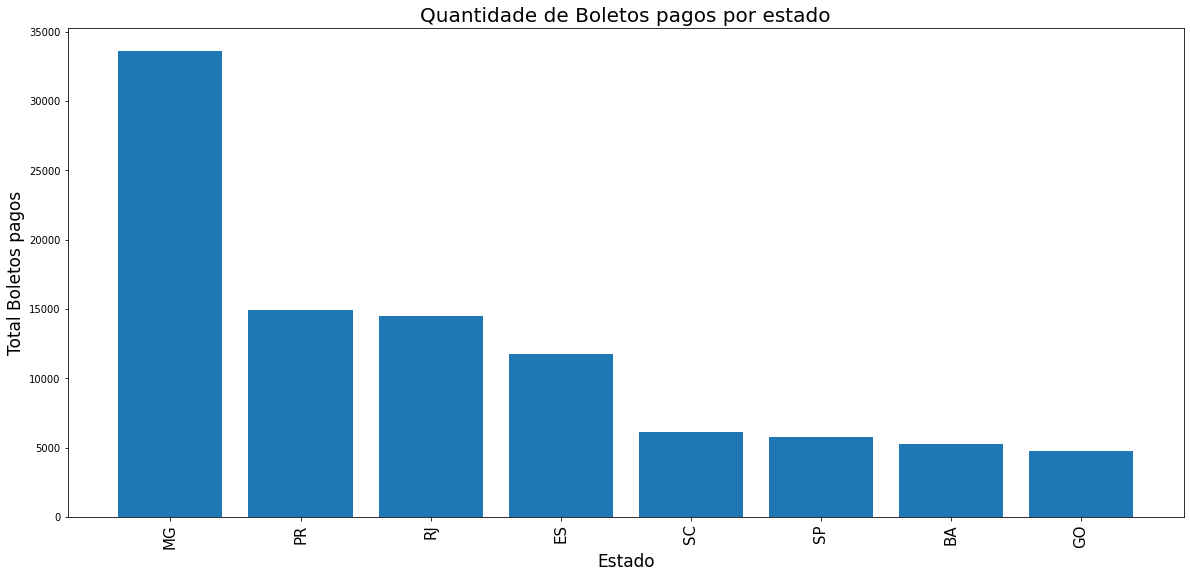

In [52]:
f,ax = plt.subplots(figsize=(20,9))

data_plot = df_paid_unpaid_to_state[['state','paid']].sort_values('paid',ascending=False)

ax.bar(data_plot['state'],data_plot['paid'])
ax.set_xticklabels(data_plot['state'].values,rotation=90,fontsize='15')
ax.set_xlabel('Estado',fontsize='17')
ax.set_ylabel('Total Boletos pagos',fontsize='17')
ax.set_title('Quantidade de Boletos pagos por estado',fontsize='20')
plt.show()

Vizualizando as contas que tem mais boletos não pagos

In [53]:
acc_largest_unpaid = df_accounts_with_address_levels_charges[['account_number','state','unpaid']].groupby(['account_number','state']).sum().reset_index()
acc_largest_unpaid.nlargest(10,'unpaid')

,account_number,state,unpaid
257,253345,MG,534
434,422360,MG,463
223,221895,MG,437
313,309054,RJ,385
361,355091,ES,356
680,662383,RJ,352
321,317265,RJ,313
926,911353,PR,313
173,164397,MG,305
82,76284,MG,291


Atenção: Vemos que dentre as 10 contas que mais tem boletos não pagos 50% são de MG confirmando o mesmo como estado de maior inadimplencia

Sobre a relação da idade com as contas ilícitas, abaixo podemos observar que, enquanto nosso público estudado possui idades entre 18 e 67 anos, as contas ilícitas foram identificadas num grupo menor que possui entre 22 e 47 anos, sendo a grande maioria entre 29 e 39 anos.

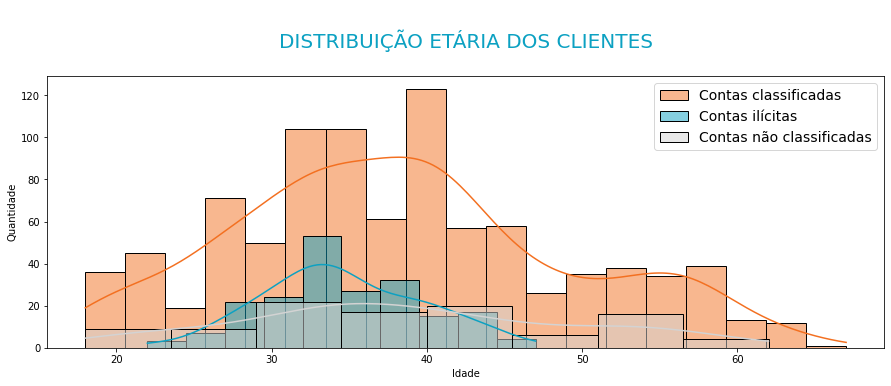

In [60]:
plt.figure(figsize=(15,5))
plt.title('\nDISTRIBUIÇÃO ETÁRIA DOS CLIENTES\n', fontsize=20, color='#0CA1C2')
sns.histplot(data=df_dim[df_dim['is_Fraud'].isin([0,1])]['age'], color='#F37021', kde=True, label='Contas classificadas')
sns.histplot(data=df_dim[df_dim['is_Fraud']==1]['age'], color='#0CA1C2', kde=True, label='Contas ilícitas')
sns.histplot(data=df_dim[df_dim['is_Fraud'].isnull()]['age'], color='lightgrey', kde=True, label='Contas não classificadas')
plt.ylabel('Quantidade')
plt.xlabel('Idade')
plt.legend(loc='upper right', ncol=1, fontsize=14)
plt.show()

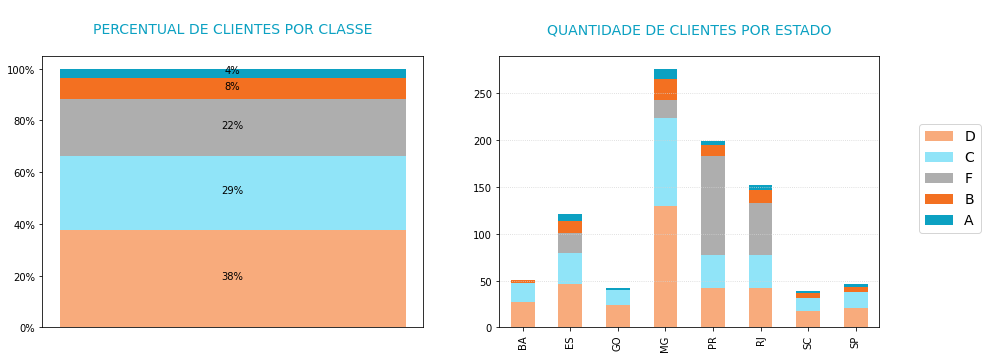

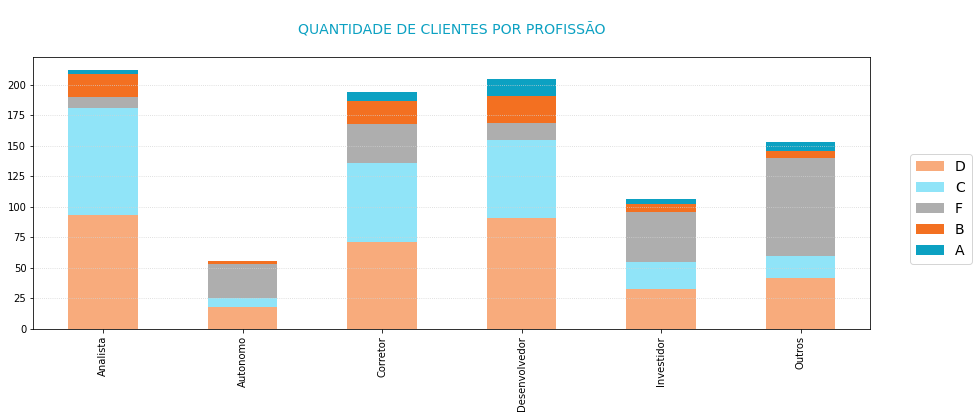

In [69]:
color = ['#F8AB7C', '#90E4F8', '#AEAEAE', '#F37021', '#0CA1C2']
class_contas = ['D', 'C', 'F', 'B', 'A']

fig, ax = plt.subplots(1, 2, figsize=(15,5))

aux= []
for i, classe in enumerate(class_contas):
    perc_class = (len(df_dim[df_dim['level'] == classe])/len(df_dim[df_dim['is_Fraud'].isin([1,0])]))*100
    aux.append(perc_class)
    ax[0].bar(x='Contas Classificadas', height=perc_class, bottom=sum(aux[:i]), color=color[i], label=classe)
ax[0].set_title('\nPERCENTUAL DE CLIENTES POR CLASSE\n', fontsize=14, color='#0CA1C2')   
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
for j, p in enumerate(ax[0].patches):
    height = p.get_height()
    ax[0].text(p.get_x()+p.get_width()/2., (sum(aux[:j+1])+sum(aux[:j]))/2, '{:.0%}'.format(height/100), ha='center')
ax[0].get_xaxis().set_visible(False)
fig.legend(loc='right', ncol=1, fontsize=14)


aux = pd.get_dummies(df_dim[['state', 'level']], columns=['level']).groupby('state').sum()
aux = aux[['level_D', 'level_C', 'level_F', 'level_B', 'level_A']]
x = aux.index
y_A = aux['level_A'].values
y_B = aux['level_B'].values
y_C = aux['level_C'].values
y_D = aux['level_D'].values
y_F = aux['level_F'].values
ax[1].set_title('\nQUANTIDADE DE CLIENTES POR ESTADO\n', fontsize=14, color='#0CA1C2')
aux.reset_index().plot(ax=ax[1], x='state', kind='bar', stacked=True, color=color, xlabel='', legend=False)
ax[1].grid(axis='y',linestyle='dotted', color='lightgrey')

plt.show()

####################################

fig, ax = plt.subplots(figsize=(15,5))

aux = pd.get_dummies(df_dim[['occupation', 'level']], columns=['level']).groupby('occupation').sum()
aux = aux[['level_D', 'level_C', 'level_F', 'level_B', 'level_A']]
aux = aux.rename(columns={'level_D':'D', 'level_C':'C', 'level_F':'F', 'level_B':'B', 'level_A':'A'})
x = aux.index
y_A = aux['A'].values
y_B = aux['B'].values
y_C = aux['C'].values
y_D = aux['D'].values
y_F = aux['F'].values
ax.set_title('\nQUANTIDADE DE CLIENTES POR PROFISSÃO\n', fontsize=14, color='#0CA1C2')
aux.reset_index().plot(ax=ax, x='occupation', kind='bar', stacked=True, color=color, xlabel='', legend=False)
ax.grid(axis='y',linestyle='dotted', color='lightgrey')
fig.legend(loc='right', ncol=1, fontsize=14)
plt.show()

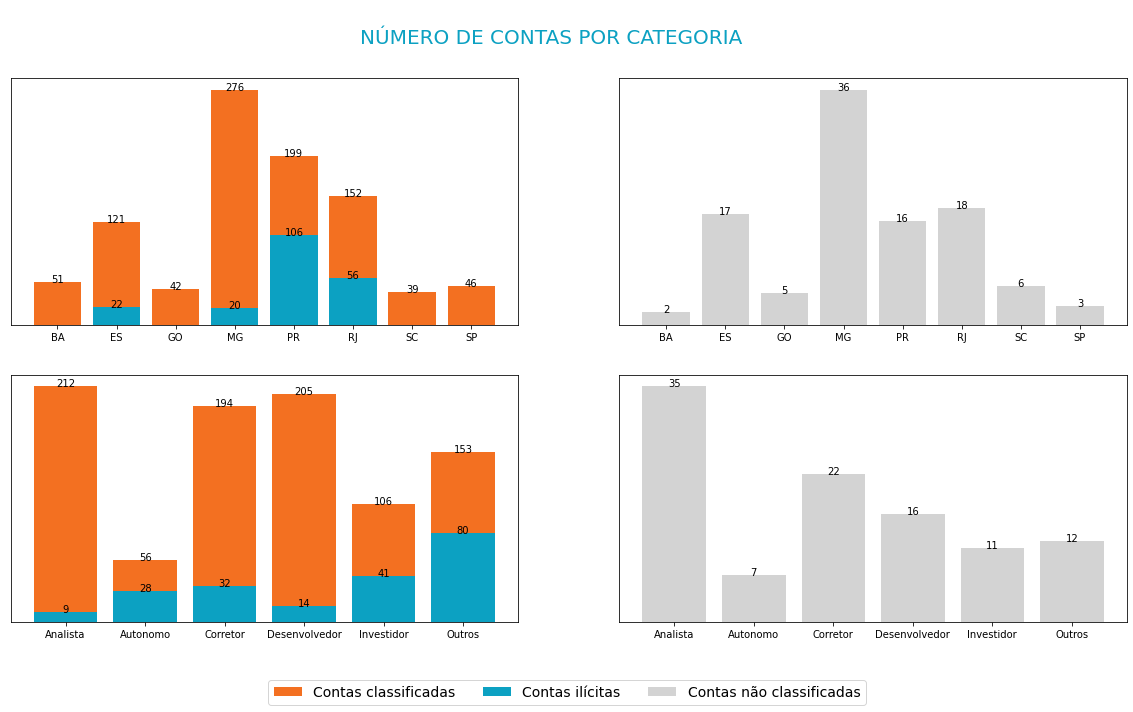

In [70]:
#####################################################################
def graph_contas(ax, groupby, filter_coluna, isin, color='#F37021', label=''):
    '''
    ax: posição do grafico ex: ax[0], ax[0,0], ax ou plt
    groupby (str): coluna de df_dim para agrupamento
    filter_coluna: coluna de df a ser filtrada
    isin (list): lista de valores contento os elemntos a serem filtrados em filter_coluna
    '''
    ax.bar(x=df_dim[df_dim[filter_coluna].isin(isin)].groupby(groupby).count().index,
        height=df_dim[df_dim[filter_coluna].isin(isin)].groupby(groupby).count()['id'].values,
        color=color, label=label)
#####################################################################    

fig, ax = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('\nNÚMERO DE CONTAS POR CATEGORIA', fontsize=20, color='#0CA1C2')
ax = ax.flatten()

graph_contas(ax[0], 'state', 'is_Fraud',[1,0],'#F37021', 'Contas classificadas')
graph_contas(ax[0], 'state', 'is_Fraud', [1],'#0CA1C2', 'Contas ilícitas')
graph_contas(ax[1], 'state', 'is_Fraud', [np.NaN],'lightgrey', 'Contas não classificadas')
graph_contas(ax[2], 'occupation', 'is_Fraud', [1,0],'#F37021')
graph_contas(ax[2], 'occupation', 'is_Fraud', [1],'#0CA1C2')
graph_contas(ax[3], 'occupation', 'is_Fraud', [np.NaN],'lightgrey')

#rotular gráficos
for grafico in ax:
    grafico.get_yaxis().set_visible(False)
    for p in grafico.patches:
        height = p.get_height()
        grafico.text(p.get_x()+p.get_width()/2., height, '{:,.0f}'.format(height), ha='center')

fig.legend(loc='lower center', ncol=3, fontsize=14)
fig.show()


In [71]:
#calcular cidades com mais fraudes
cidades = df_dim.groupby('city').sum().sort_values('is_Fraud', ascending=False).index
total_fraudes = df_dim.groupby('city').sum().sort_values('is_Fraud', ascending=False)['is_Fraud'].values

fraudes_cidade = pd.DataFrame(total_fraudes, index=cidades).rename(columns={0: 'Total Fraudes'})
fraudes_cidade['% Fraudes'] = (fraudes_cidade['Total Fraudes']/fraudes_cidade['Total Fraudes'].sum())*100

fraudes_cidade = fraudes_cidade.join(df_address[['state', 'city']].set_index('city'), on='city', how='left')

top5_problemas = fraudes_cidade.sort_values('% Fraudes', ascending=False)[:5]
print('\nTop5 Cidades com Mais Fraudes:')
display(top5_problemas)


Top5 Cidades com Mais Fraudes:


,Total Fraudes,% Fraudes,state
city,,,
Mangaratiba,4.0,1.960784,RJ
Jesuitas,3.0,1.470588,PR
Boa Esperanca do Iguacu,3.0,1.470588,PR
Engenheiro Paulo de Frontin,3.0,1.470588,RJ
Italva,3.0,1.470588,RJ


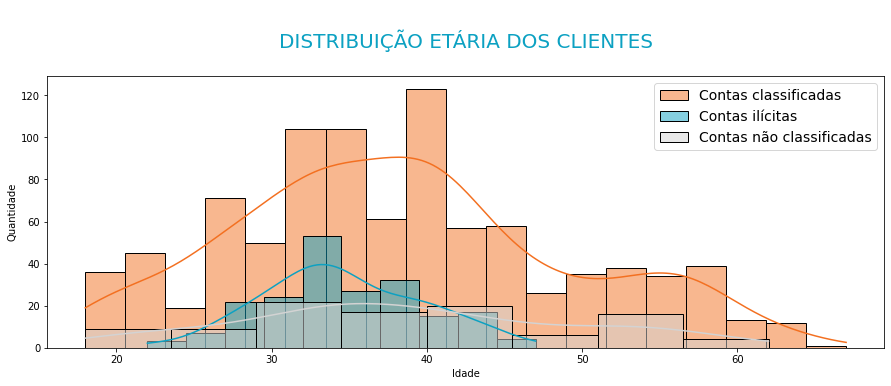

In [90]:
plt.figure(figsize=(15,5))
plt.title('\nDISTRIBUIÇÃO ETÁRIA DOS CLIENTES\n', fontsize=20, color='#0CA1C2')
sns.histplot(data=df_dim[df_dim['is_Fraud'].isin([0,1])]['age'], color='#F37021', kde=True, label='Contas classificadas')
sns.histplot(data=df_dim[df_dim['is_Fraud']==1]['age'], color='#0CA1C2', kde=True, label='Contas ilícitas')
sns.histplot(data=df_dim[df_dim['is_Fraud'].isnull()]['age'], color='lightgrey', kde=True, label='Contas não classificadas')
plt.ylabel('Quantidade')
plt.xlabel('Idade')
plt.legend(loc='upper right', ncol=1, fontsize=14)
plt.show()

Análise das Transações:

Como tivemos indícios que os valores médios das transações estão correlacionados as contas classe F, outra observação importante que pode ser feita é sobre os valores emitidos nos boletos e suas transações efetivadas, tentando entender melhor a diferença destas movimentações entre os clientes que possuem contas lícitas e ilícitas.

Abaixo temos a visualização gráfica destas informações através de boxplots e podemos notar que:

Valores dos boletos (não recebidos/recebidos) e pix recebidos:

Estes três gráficos são muito parecidos, podendo tirar as mesmas conclusões.

Nas contas classificadas como F a mediana dos valores fica próximo a 8.000 enquanto nas outras classes gira entorno de 5.000, 60% abaixo;
Enquanto nas contas ilícitas os valores destes boletos chegam a quase 14.000, nas contas lícitas valores acima de 9.000 são considerados como exceções, 55% abaixo.